# Preparation

## import libraries

In [2]:
import numpy as np
import scipy.signal as sig
from scipy.linalg import toeplitz
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

## load given data

In [4]:
# load provided data
FIR = sio.loadmat('AF2018/System_FIR3.mat')
IIR = sio.loadmat('AF2018/System_IIR3.mat')
FIRx = sio.loadmat('AF2018/Systemwechsel_FIR3.mat')
IIRx = sio.loadmat('AF2018/Systemwechsel_IIR3.mat')
# input signal
Xfir = FIR['X'][0].astype('float64')
Xiir = IIR['X'][0].astype('float64')
Xfirx = FIRx['X'][0].astype('float64')
Xiirx = IIRx['X'][0].astype('float64')
# desired signal
Dfir = FIR['D_'][0][0:10000].astype('float64')
Diir = IIR['D_'][0][0:10000].astype('float64')
Dfirx = FIRx['D_'][0][0:10000].astype('float64')
Diirx = IIRx['D_'][0][0:10000].astype('float64')

## Implementation of least mean squares algorithm

In [5]:
# reference Moschytz, G., & Hofbauer, M. (2000). 
# Adaptive Filter. Berlin ua: Springer. p.121

def lms_update(x,d,w,mu=0.01):
    '''
    perform a least mean square weight update.
    takes an input signal x, the disred signal d and he prior 
    weight vector to calculate the momentary error and update the weigths.
    '''
    # predict y by scalar product of w and x.
    y = np.dot(w,x)
    # obtain error as difference to d.
    e = d - y
    # update w by scaled version of x.
    w_new = w + mu * e * x
    
    # record error squared for performance measure.
    error = e**2
    
    return w_new, error


def lms(N,d,x,mu=0.01):
    '''
    performs the least mean square algorithm on every samples.
    takes the number of taps 'N', a disred signal 'd', an input signal 'x'
    and a learning rate 'mu' and returns the history of 
    weight vectors 'w' and error 'e'.
    '''
    # for each iteration we want N pervious values of x.
    # in toeplitz each column holds the previous terms in descending order.
    # limit number of rows to N.
    X = toeplitz(x)[:N,:]
    
    # prealloacte wight vector and error history.
    w = np.zeros((N,len(d)+1))
    error = np.zeros(len(d))
    
    # iterate over signal and recursively update the weights.
    for i in range(0,len(d)):
        # record output of lms_update and feed it back to it.
        w[:,i+1],error[i] = lms_update(X[:,i],d[i],w[:,i],mu)
    
    return w, error

## Implementation of recursive least squares algorithm

In [6]:
# reference Moschytz, G., & Hofbauer, M. (2000). 
# Adaptive Filter. Berlin ua: Springer. p.145

def rls_update(x,d,Rinv,w,rho):
    '''
    perform a recursive least squares weight update.
    takes an input signal 'x', the disred signal 'd', the 
    prior inverted determinist autocorrelation matrix 'Rinv',
    and the prior weight vector 'w' to calculate the momentary error,
    update the weigths 'w' and update 'Rinv'.
    '''
    # predict y by scalar product of w and x
    y = np.dot(w,x)
    # obtain error as difference to d
    e = d - y
    # filtered normalized data vector
    z = np.dot(Rinv,x[:,None]) / (1 + np.dot(x[None,:],Rinv).dot(x[:,None]))
    # update w by adding scaled version of z
    w_new = w[:,None] + e * z
    # update Rinv
    Rinv = (1/rho) * (Rinv - np.dot(z,x[None,:]).dot(Rinv))
    return w_new[:,0], Rinv, e**2

def rls(N,d,x,rho=1,eta=1000000):
    '''
    performs the recursive least squares algorithm on every samples.
    takes the number of taps 'N', a disred signal 'd', an input signal 'x'
    and an initial value for Rinv 'eta' and returns history of 
    weight vectors 'w' and error 'e'.
    '''
    X = toeplitz(x)[:N,:] # every column is input for time t

    Rinv = eta * np.eye(N,N)
    # initialize wight vector and error history
    w = np.zeros((N,len(d)+1))
    error = np.zeros(len(d))
    
    # compute rlms for every point
    for i in range(0,len(d)):
        # update weight vector and collect error
        w[:,i+1], Rinv, error[i] = rls_update(X[:,i],d[i],Rinv,w[:,i],rho)
    
    return w, error

## helper functions for plotting

In [7]:
def rms(X):
    '''
    standart root mean square, 
    expects X to be a row vector
    '''
    return 1/X.shape[0]*np.sum(np.square(X))

def addnoise(X,var):
    '''
    adds noise of variance 'var' to input vector X
    it will help simulate measurement noise
    '''
    length = X.shape
    std = np.sqrt(var)
    XN = X + np.random.normal(0,std,length)
    return XN

def smooth(X,N=200):
    '''
    smoothing vector X 
    by moving average of N=200 values
    '''
    window = np.ones((N,))/N
    return np.convolve(X,window,mode='valid')

def plot(values,label='',stop=-1):
    '''
    automatically applies smoothing
    and sets defaults for linewidth and legends
    '''
    plt.xlabel('setp of iteration'); plt.ylabel('squared prediction error')
    plt.plot(smooth(values[:stop]),linewidth=0.5,label=label);
    plt.legend(); 

# Fehlerfläche

In [8]:
# ideale Filterung:
R = np.array([[1,0],[0,1]])
p = np.array([0.7, 0.1])
w = np.array([ 1.20519592, -0.08201364])
sigma = 1
J = sigma + w@R@w + 2*p@w

In [9]:
def sig_stats(N,d,x):
    '''
    'N' numer of taps, 'd' Desired Signal, 'x' Input Signal
    Returns 'sigma', autocorrelation 'R' and crosscorrelation 'p'
    '''
    # initialize matrices
    X = toeplitz(x)[:N,:]
    R = np.zeros((N,N,x.shape[0]))
    p = np.zeros((x.shape[0],N))
    
    # for every time step i calculate the corresponding
    # autocorrelation matrix and crosscorelation matrix
    for i in range(0,x.shape[0]):
        x_i = X[:,i]
        p[i,:] = d[i]*x_i
        R_i = np.outer(x_i,x_i)
        R[:,:,i] = R_i
    sigma = rms(x)
    
    # take mean of all time steps
    Rmean = np.mean(R,axis=2)
    pmean = np.mean(p,axis=0)
    return sigma,Rmean,pmean 

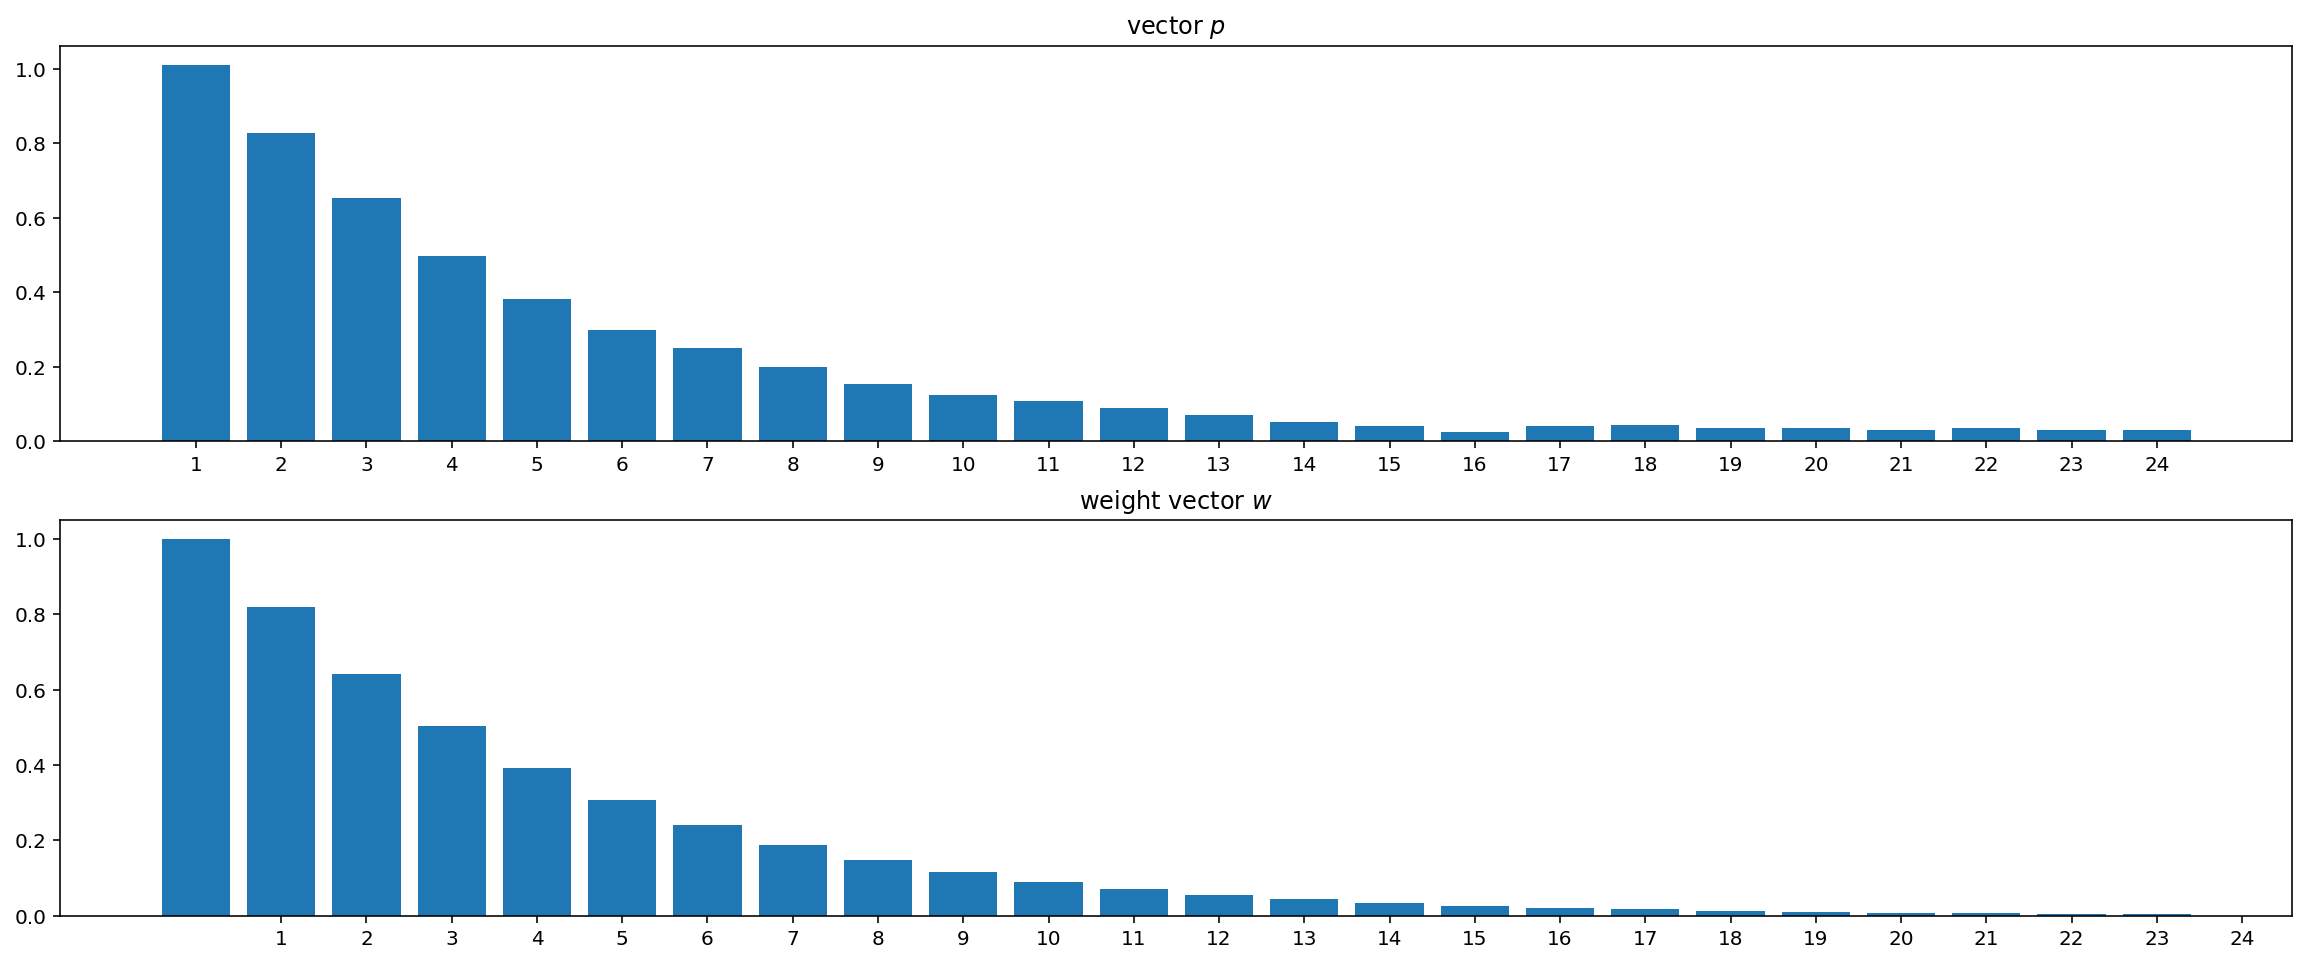

In [10]:
# compare signal vector p to the optimal eigenvectors of w
sig,R,p = sig_stats(24,Diir,Xiir)
plt.subplot(2,1,1)
plt.bar(range(1,p.shape[0]+1),p)
plt.xticks(range(1,p.shape[0]+1))
plt.title('vector $p$')
plt.subplot(2,1,2)
w = lms(24,Diir,Xiir)[0][:,-1]
plt.bar(range(w.shape[0]),w)
plt.xticks(range(1,w.shape[0]+1))
plt.title('weight vector $w$');

Text(0.5,1,'autocorrelation matrix $R$')

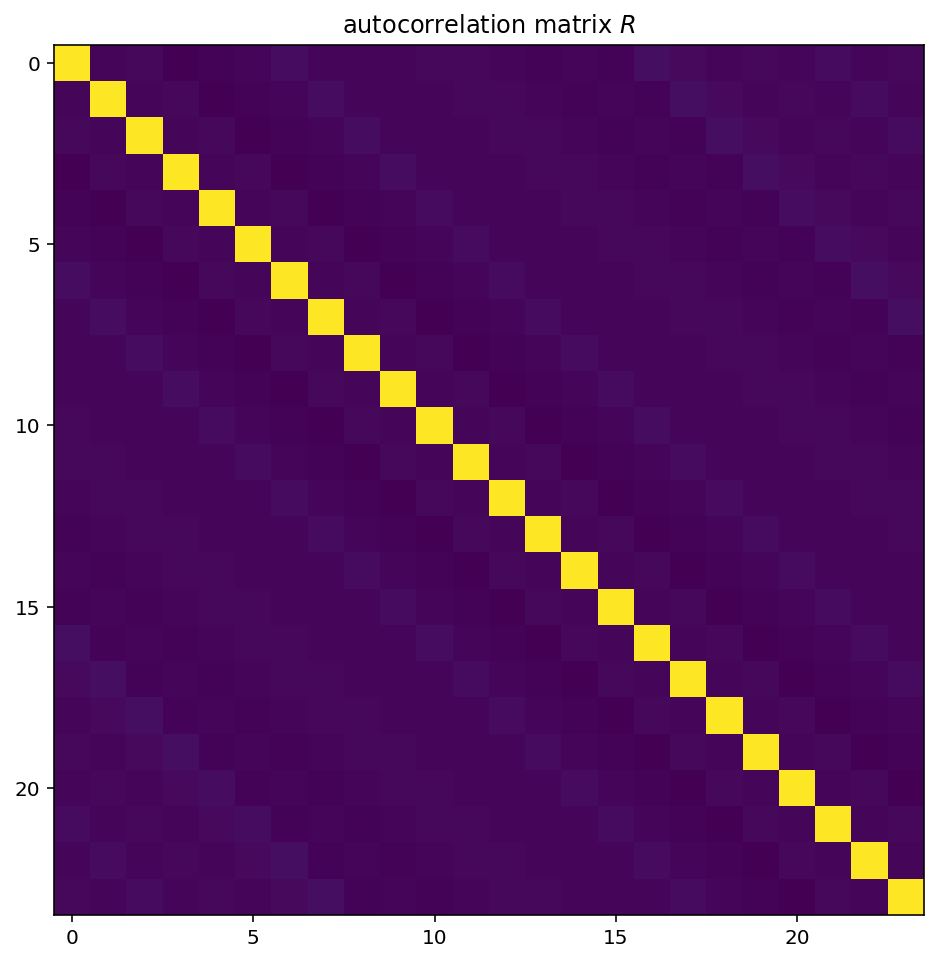

In [11]:
# take a look at the autocorrelation matrix
plt.imshow(R); plt.title('autocorrelation matrix $R$')

In [12]:
def error_fun(sig,R,p,w):
    '''
    returns the prediction error of a FIR Filter specified by w.
    requires the signal variance 'sig', the autocorrelation matrix 'R'
    and the crosscorrelation vector 'p' of disred vs input signal.
    '''
    J = sigma + w@R@w - 2*p@w
    return J

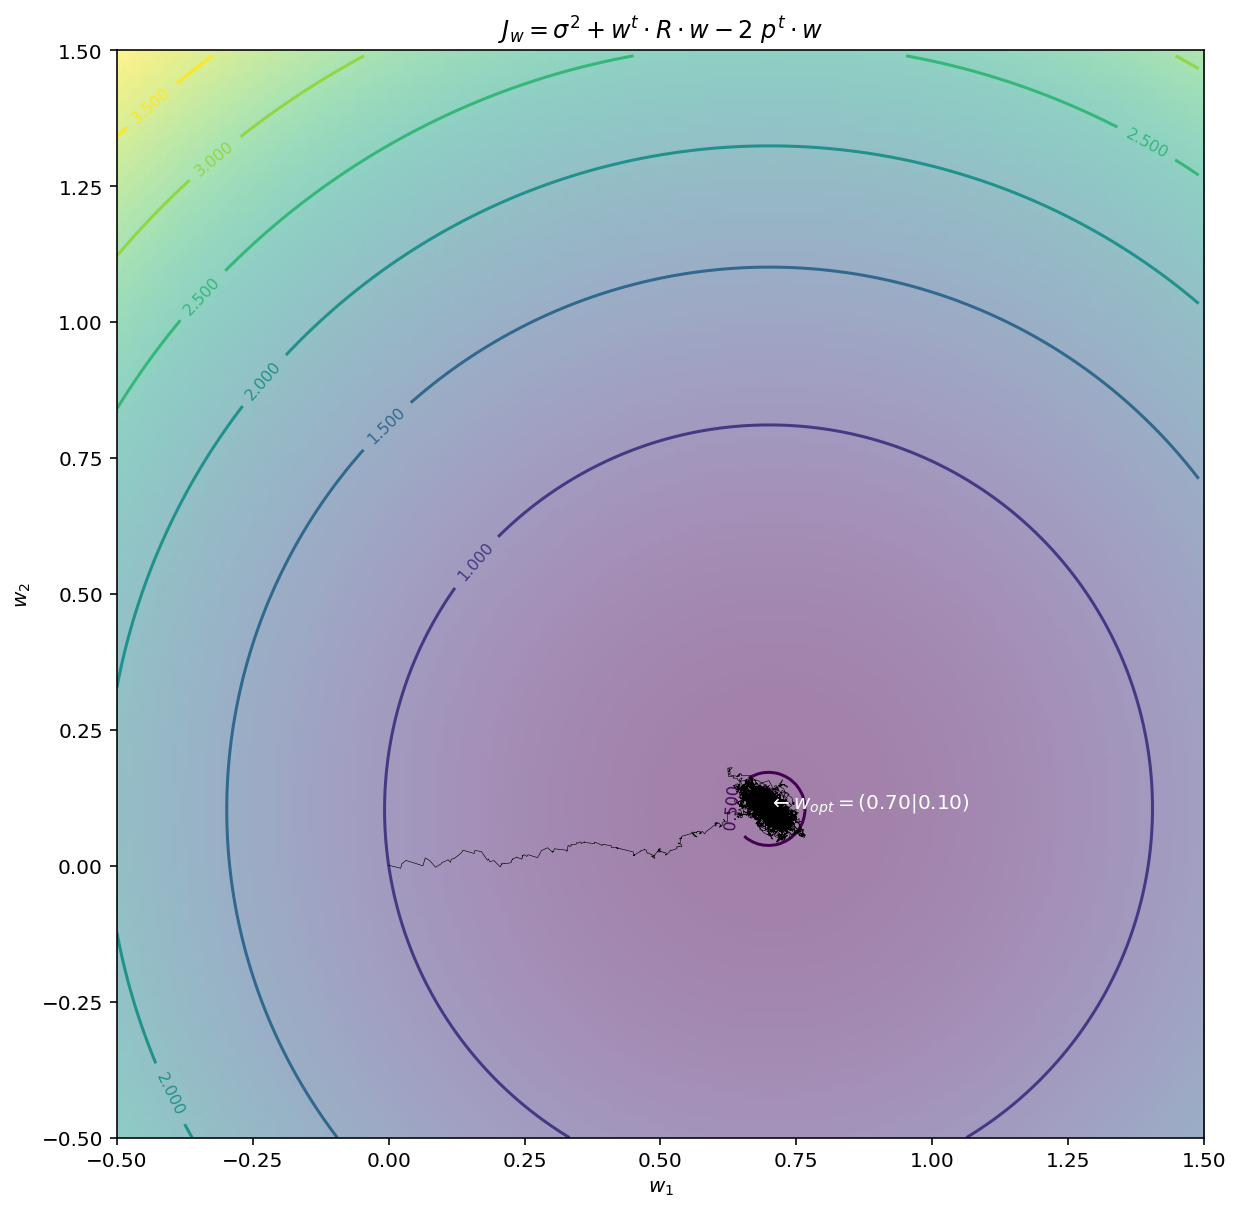

In [13]:
from scipy.linalg import inv

def plt_errsurf(mini,maxi,d,x):
    # get estimation of signal statistics
    sig,R,p = sig_stats(2,d,x)
    
    # calculate error surface
    wvals = np.arange(mini,maxi,0.01)
    J = np.zeros((len(wvals),len(wvals)))
    for i,w0 in enumerate(wvals):
        for j,w1 in enumerate(wvals):
            w = np.array([w0,w1])
            J[j,i] = error_fun(sig,R,p,w) 
    
    levels = np.arange(0,100,0.5)
    # give countours
    plt.figure(figsize=(10,10))
    contours = plt.contour(wvals,wvals,J)
    # label countours with corresponding value of J
    plt.clabel(contours, inline=True, fontsize=8)
    # fill with color gradient
    plt.imshow(J,extent=[mini,maxi,mini,maxi],origin='lower',alpha=0.5)
    
    # plot gradient descent
    w = lms(2,d,x)[0]
    plt.plot(w[0],w[1],'k',linewidth='0.3')
    
    # add annotation of optimal weight vector
    wopt = inv(R)@p
    annotation = (r'$\leftarrow w_{opt} = (%.2f|%.2f)$')
    position = (wopt[0],wopt[1])
    plt.annotate(annotation %position, position,color='w')
    #plt.text(0,0,r'with $ J_{w_{opt}}=%.2f$' % (error_fun(sig,R,p,wopt)))
    
    # add title and labels for axis
    plt.xlabel('$w_1$'),plt.ylabel('$w_2$')
    plt.title(r'$J_w = \sigma^2 + w^t\cdot R \cdot w - 2\ p^t \cdot w$')
    return w
   
w = plt_errsurf(-.5,1.5,addnoise(Dfir,0.001),Xfir)

misadjusment of 10% of the Jmin is viewed as satisfactory in practice. 
See 2.1.3 in Haykin Kernel least mean squares Algorith